
#### Run the cell below to install the required packages for Copilot


In [ ]:
# Run this cell to install the required packages for Copilot
%load_ext dscopilot_installer
%activate_dscopilot

# Contoso Hypermarket Orders sales forecast ML notebook

## Case 1: Forecast sales across products for a particular store location.

#### Set up MLflow experiment tracking

In [2]:
# Set up MLflow for experiment tracking
import mlflow

IS_SAMPLE = False  # if TRUE, use only rows of data for training, otherwise use all data
SAMPLE_ROWS = 5000  # if IS_SAMPLE is True, use only this number of rows for training
EXPERIMENT_NAME = "orders-sales-forecast"  # MLflow experiment name

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Disable MLflow autologging

StatementMeta(, 3945a8d4-06c7-4a20-bac5-81538ccc6266, 3, Finished, Available, Finished)

### Step 1: Ingest data
#### Load orders data from KQL database to prepare for ML modeling

> [!IMPORTANT]
> Make sure you have enough data generated using data emulator.

In [2]:
# Read from Kusto
# kustoQuery = "['orders'] |  mv-expand li = parse_json(line_items) | project order_date, store_id, order_id, product_id = toint(li.product_id), quantity = toint(li.quantity), price = toreal(li.price), item_total = toreal(li.item_total), order_total"
ordersQuery = "['orders'] |  mv-expand li = parse_json(line_items) | project order_date, store_id, order_id, product_id = toint(li.product_id), quantity = toint(li.quantity), price = toreal(li.price), item_total = toreal(li.item_total), order_total"
inventoryQuery = "['inventory'] | project date_time, store_id, product_id, in_stock, retail_price"
productsQuery = "['products'] | project product_id, name, category, photo_path, price_range, stock"
# The query URI for reading the data e.g. https://<>.kusto.data.microsoft.com.
kustoUri = "{{KQL_CLUSTER_URI}}"
# The database with data to be read.
database = "{{KQL_DATABASE_NAME}}"
# The access credentials.
accessToken = mssparkutils.credentials.getToken(kustoUri)
ordersDf  = spark.read\
    .format("com.microsoft.kusto.spark.synapse.datasource")\
    .option("accessToken", accessToken)\
    .option("kustoCluster", kustoUri)\
    .option("kustoDatabase", database)\
    .option("kustoQuery", ordersQuery).load()
inventoryDf  = spark.read\
    .format("com.microsoft.kusto.spark.synapse.datasource")\
    .option("accessToken", accessToken)\
    .option("kustoCluster", kustoUri)\
    .option("kustoDatabase", database)\
    .option("kustoQuery", inventoryQuery).load()
productsDf  = spark.read\
    .format("com.microsoft.kusto.spark.synapse.datasource")\
    .option("accessToken", accessToken)\
    .option("kustoCluster", kustoUri)\
    .option("kustoDatabase", database)\
    .option("kustoQuery", productsQuery).load()

StatementMeta(, 1aeb6edd-3450-4a72-a646-81cab3450974, 5, Finished, Available, Finished)

#### Verifying token availability

In [3]:
import requests

# Define a simple test query
test_query = "['inventory'] | take 1"

# Define the request headers with the access token
headers = {
    "Authorization": f"Bearer {accessToken}",
    "Content-Type": "application/json"
}

# Define the request payload
payload = {
    "db": database,
    "csl": test_query
}

# Make the request to the Kusto cluster
response = requests.post(f"{kustoUri}/v1/rest/query", headers=headers, json=payload)

# Check if the request was successful
if response.status_code == 200:
    print("Access token is valid and has the necessary permissions.")
else:
    print(f"Failed to validate access token. Status code: {response.status_code}, Response: {response.text}")

StatementMeta(, 1aeb6edd-3450-4a72-a646-81cab3450974, 6, Finished, Available, Finished)

Access token is valid and has the necessary permissions.


### Step 2: Perform Exploratory Data Analysis

#### Import libraries

Before any analysis, you need to import the required libraries.

In [4]:
# Importing required libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

StatementMeta(, 1aeb6edd-3450-4a72-a646-81cab3450974, 7, Finished, Available, Finished)

#### Display raw data

In [5]:
# Display data in dataframes.
ordersDf.show()
productsDf.show()
inventoryDf.show()

StatementMeta(, 1aeb6edd-3450-4a72-a646-81cab3450974, 8, Finished, Available, Finished)

+--------------------+--------+------------------+----------+--------+-----+------------------+------------------+
|          order_date|store_id|          order_id|product_id|quantity|price|        item_total|       order_total|
+--------------------+--------+------------------+----------+--------+-----+------------------+------------------+
|2024-09-26 13:25:...|     NYC|20240926132502-003|        12|       8|  3.0|              24.0|             60.95|
|2024-09-26 13:25:...|     NYC|20240926132502-003|         4|      10|  3.0|              30.0|             60.95|
|2024-09-26 13:25:...|     NYC|20240926132502-003|         9|      10|  0.2|               2.0|             60.95|
|2024-09-26 13:25:...|     NYC|20240926132502-003|         2|       3| 0.15|              0.45|             60.95|
|2024-09-26 13:25:...|     NYC|20240926132502-003|         8|       8|  0.5|               4.0|             60.95|
|2024-09-26 13:25:...|     NYC|20240926132502-003|         7|       2| 0.25|    

##### Demonstrate the impact order date on the sales for all sales in Chicago.
1. Filters sales data for the Chicago store.
2. Computes total sales per order by multiplying price and quantity.
3. Groups and sums daily sales data, then resamples it to monthly totals.
4. Converts data to Pandas and ensures order_date is in datetime format.
5. Plots the monthly sales trend over time, showing the impact of order date on sales in Chicago.

StatementMeta(, 1aeb6edd-3450-4a72-a646-81cab3450974, 9, Finished, Available, Finished)

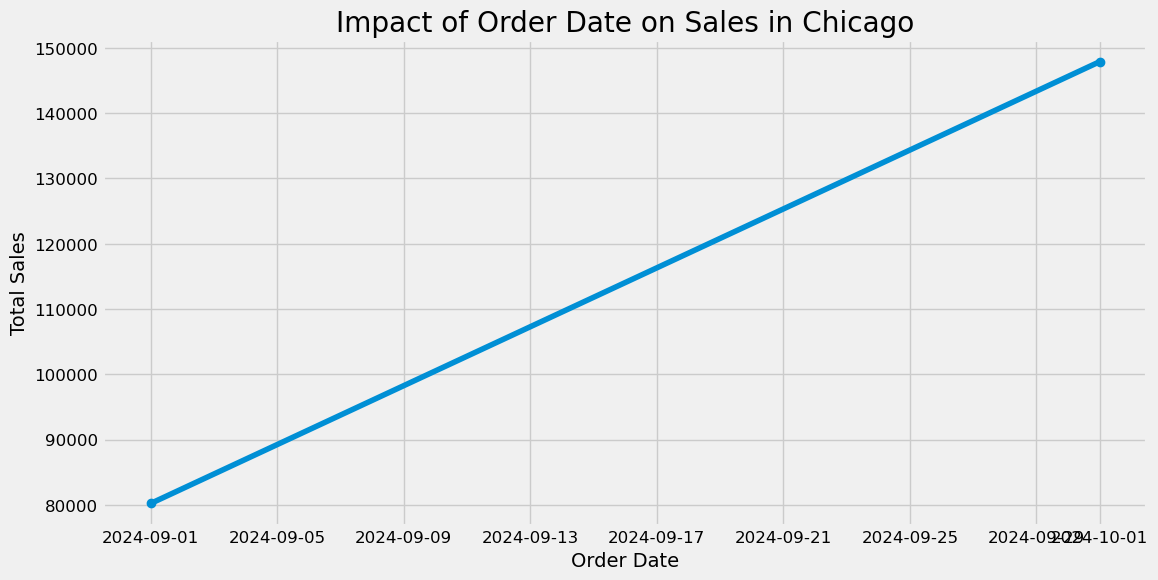

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtering Chicago data
sales_chicago_df = ordersDf.filter(ordersDf.store_id == 'CHI')

# Creating a 'sales' column by multiplying price and quantity
sales_chicago_df = sales_chicago_df.withColumn('sales', sales_chicago_df['price'] * sales_chicago_df['quantity'])

# Selecting relevant columns: order_date, sales
sales_chicago_df = sales_chicago_df.select('order_date', 'sales')

# Converting the DataFrame to Pandas
sales_chicago_pd_df = sales_chicago_df.toPandas()

# Confirming that 'order_date' is in datetime format
sales_chicago_pd_df['order_date'] = pd.to_datetime(sales_chicago_pd_df['order_date'])

# Group by 'order_date' and sum the sales
sales_chicago_pd_df = sales_chicago_pd_df.groupby('order_date')['sales'].sum().reset_index()

# Resample the data to get monthly sales
sales_chicago_pd_df.set_index('order_date', inplace=True)
sales_chicago_monthly = sales_chicago_pd_df['sales'].resample('MS').sum().reset_index()

# Plot sales over time
plt.figure(figsize=(12, 6))
plt.plot(sales_chicago_monthly['order_date'], sales_chicago_monthly['sales'], marker='o')

# Adding labels and title
plt.xlabel('Order Date')
plt.ylabel('Total Sales')
plt.title('Impact of Order Date on Sales in Chicago')

plt.show()

### Step 3: Statistical Analysis
1. Simulates Sales Data: Generates 36 months of random sales data to simulate monthly sales values.
2. Decomposes Time Series: Uses seasonal_decompose from statsmodels to break down the sales data into trend, seasonality, and residual components.
    - Trend: Shows the long-term movement in sales, whether increasing, decreasing, or stable.
    - Seasonality: Reveals recurring patterns or cycles within specific time intervals (like monthly or yearly).
    - Residual (Noise): Represents random fluctuations in the data that cannot be explained by trend or seasonality.
3. Organizes Data for Plotting: Prepares labels and corresponding data for the time series components.
4. Plots Components: Creates subplots to visualize seasonality, trend, residuals, and observed sales data, making it easier to analyze patterns in the simulated data.

In [9]:
import statsmodels.api as sm

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 11, Finished, Available, Finished)

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 12, Finished, Available, Finished)

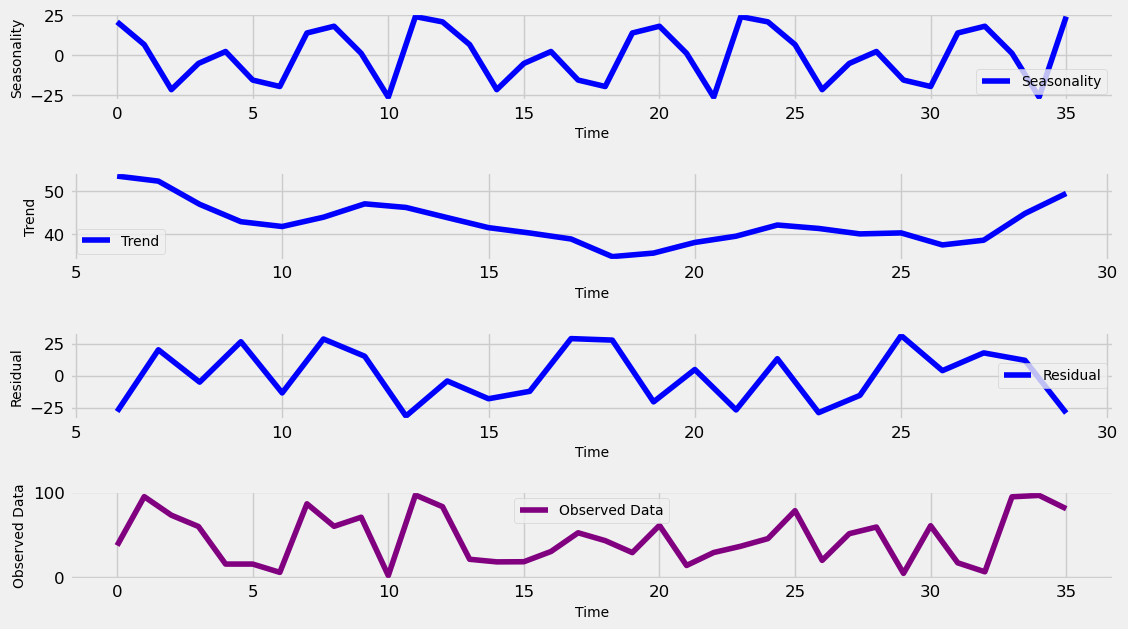

In [10]:
import pandas as pd
import numpy as np

# Simulate additional monthly sales data for testing
dates = pd.date_range(start='2023-01-01', periods=36, freq='MS')  # Extended to 36 months for more data
np.random.seed(42)  # For reproducibility
sales = np.random.rand(36) * 100  # Random sales data

# Create a DataFrame with the simulated data
simulated_sales_df = pd.DataFrame({'order_date': dates, 'sales': sales})

# Decompose the time series into its components using statsmodels
import statsmodels.api as sm
result = sm.tsa.seasonal_decompose(simulated_sales_df['sales'], model='additive', period=12)

# Labels and corresponding data for plotting
components = [('Seasonality', result.seasonal),
              ('Trend', result.trend),
              ('Residual', result.resid),
              ('Observed Data', simulated_sales_df['sales'])]

# Create subplots in a grid
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.8)  # Adjust vertical space
axes = axes.ravel()

# Plot the components
for ax, (label, data) in zip(axes, components):
    ax.plot(data, label=label, color='blue' if label != 'Observed Data' else 'purple')
    ax.set_xlabel('Time')
    ax.set_ylabel(label)
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel(label, fontsize=10)
    ax.legend(fontsize=10)

plt.show()

### Step 4: Model Training and Tracking

#### Adding and massaging data.
1. Sets Up Date Range: Creates a 3-year monthly date range for generating sample data.
2. Simulates Seasonality: Adds a sinusoidal pattern to represent a recurring seasonal effect in sales.
3. Adds a Linear Trend: Creates an increasing sales trend over time by adding a linear component.
4. Introduces Noise: Adds random noise to make the data more realistic and less predictable.
5. Combines Components: Combines the seasonal, trend, and noise elements into a final sales dataset with a baseline value.
6. Scales Sales Data: Uses MinMaxScaler to scale the sales data (helpful for models like SARIMAX that require scaling).
7. Plots Simulated Data: Visualizes the simulated sales data over time, showing the trend and seasonality.

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 13, Finished, Available, Finished)

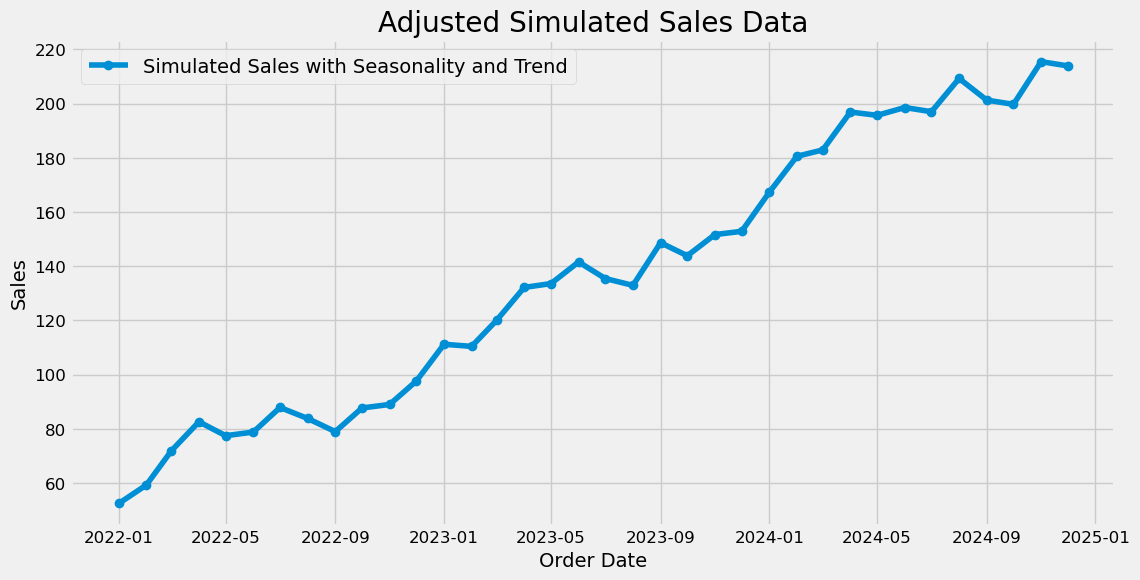

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Let's create a sample 'simulated_sales_df' DataFrame with a trend and seasonality
date_range = pd.date_range(start="2022-01-01", periods=36, freq='MS')  # 3 years of monthly data
np.random.seed(42)  # For reproducibility

# Simulate a basic seasonal pattern with a sinusoidal component
seasonal_pattern = 10 * np.sin(2 * np.pi * np.arange(len(date_range)) / 12)

# Add a linear trend component (e.g., increasing sales)
trend_component = np.arange(len(date_range)) * 5

# Add some random noise to make the data more realistic
noise = np.random.normal(0, 5, len(date_range))

# Combine these components to create the 'sales' data
sales_data = 50 + trend_component + seasonal_pattern + noise  # Start with a base sales level

# Create DataFrame to mimic 'simulated_sales_df'
simulated_sales_df = pd.DataFrame({
    'order_date': date_range,
    'sales': sales_data
})

# Scale the sales data as done typically for SARIMAX
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
simulated_sales_df['scaled_sales'] = scaler.fit_transform(simulated_sales_df[['sales']])

# Plot the adjusted simulated data
plt.figure(figsize=(12, 6))
plt.plot(simulated_sales_df['order_date'], simulated_sales_df['sales'], label='Simulated Sales with Seasonality and Trend', marker='o')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('Adjusted Simulated Sales Data')
plt.legend()
plt.show()

#### Scaling data.

In [12]:
# Scaling the sales data only if it's not already scaled properly
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(simulated_sales_df[['sales']])

# Update simulated_sales_df with the scaled values for the model to train on
simulated_sales_df['scaled_sales'] = scaled_sales

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 14, Finished, Available, Finished)

#### Model training.
1. Define Hyperparameter Ranges: Sets ranges for SARIMAX model parameters (p, d, q) and creates combinations for both non-seasonal (pdq) and seasonal parameters (seasonal_pdq with a 12-month seasonality).
2. Initialize Best Model Tracking: Sets placeholders for the best AIC (model performance metric), and corresponding parameters.
3. Iterate Through Parameter Combinations: Tests each combination of (pdq) and (seasonal_pdq) by fitting a SARIMAX model to the scaled_sales data.
4. Track Best Model: If a model's AIC score is lower than the current best, updates best_aic, best_param, and best_param_seasonal to store the optimal parameters.
5. Print Best Parameters: Outputs the optimal (pdq) and (seasonal_pdq) parameters along with the lowest AIC score.
6. Fit Final Model: Fits a SARIMAX model using the best parameters found for scaled_sales.

In [13]:
# Hyperparameter tuning for SARIMAX
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

best_aic = float("inf")
best_param = None
best_param_seasonal = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(simulated_sales_df['scaled_sales'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_param = param
                best_param_seasonal = param_seasonal
        except:
            continue

print(f'Best ARIMA{best_param}x{best_param_seasonal}12 - AIC:{best_aic}')

# Fit the best SARIMAX model on scaled data
mod = sm.tsa.statespace.SARIMAX(simulated_sales_df['scaled_sales'],
                                order=best_param,
                                seasonal_order=best_param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(disp=False)

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 15, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Best ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-109.61193341586926


#### Model diagonostics for SARIMAX model.
- Residuals Plot: Look for randomness around zero. Any patterns or trends indicate model inadequacy.
- Histogram and KDE Plot: Check for normal distribution centered around zero. Skewness or heavy tails suggest poor fit.
- Q-Q Plot: Points should lie along the 45-degree line. Deviations indicate non-normal residuals.
- Correlogram (ACF Plot): Significant autocorrelations suggest the model is not capturing temporal dependencies.

In [14]:
# Print model summary
print(results.summary())

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 16, Finished, Available, Finished)

                               SARIMAX Results                                
Dep. Variable:           scaled_sales   No. Observations:                   36
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  56.806
Date:                Sat, 02 Nov 2024   AIC                           -109.612
Time:                        23:11:45   BIC                           -106.501
Sample:                             0   HQIC                          -108.538
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0369      0.013     77.347      0.000       1.011       1.063
sigma2         0.0023      0.001      2.333      0.020       0.000       0.004
Ljung-Box (L1) (Q):                   1.08   Jarque-

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 17, Finished, Available, Finished)

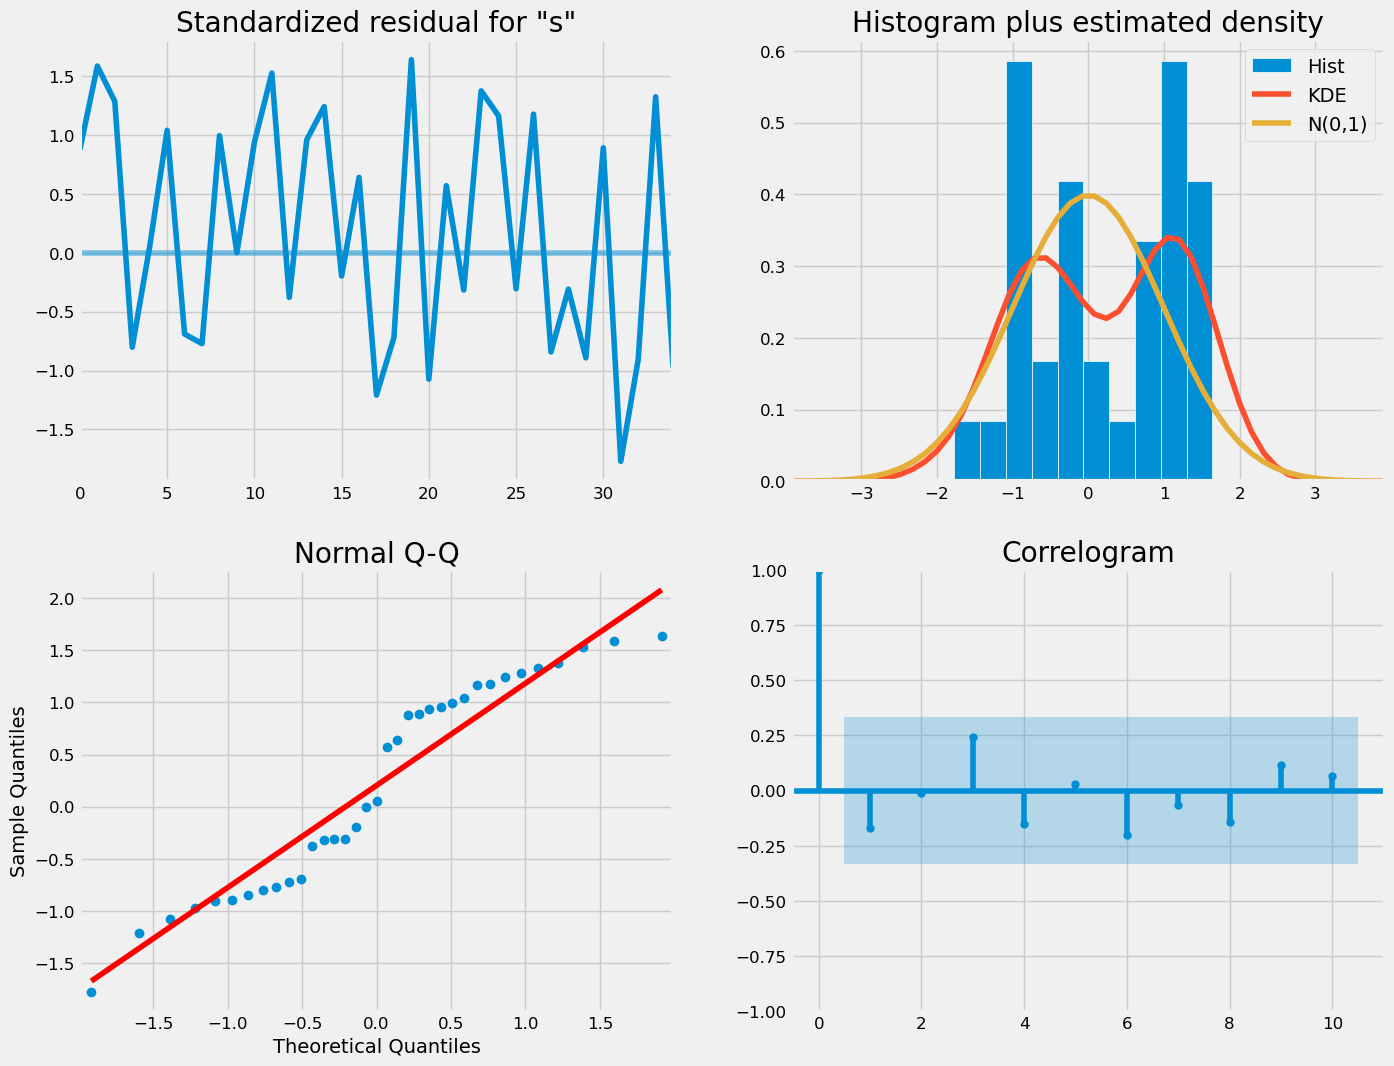

In [15]:
# Plot diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

#### Plotting forecasted data.

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 19, Finished, Available, Finished)

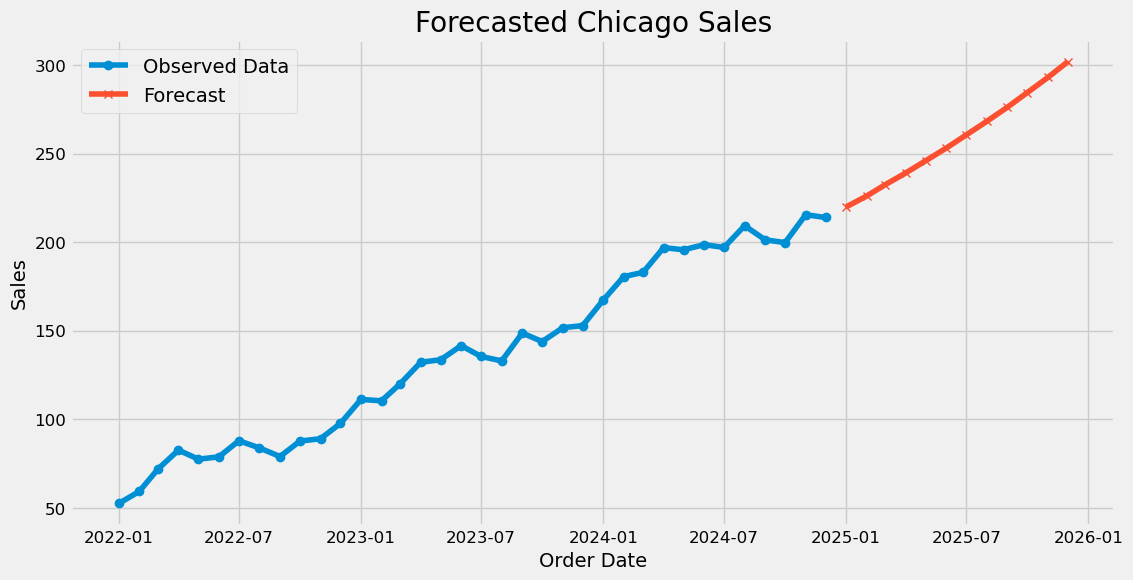

In [17]:
# Forecasting the next 12 months
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=simulated_sales_df['order_date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
forecast_scaled = forecast.predicted_mean.values.reshape(-1, 1)

# Apply inverse transformation to get the forecast back to original scale
forecast_original_scale = scaler.inverse_transform(forecast_scaled)
forecast_df = pd.DataFrame({'order_date': forecast_index, 'forecast': forecast_original_scale.flatten()})

# Plot the observed data and forecast
plt.figure(figsize=(12, 6))
plt.plot(simulated_sales_df['order_date'], simulated_sales_df['sales'], label='Observed Data', marker='o')
plt.plot(forecast_df['order_date'], forecast_df['forecast'], label='Forecast', marker='x')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('Forecasted Chicago Sales')
plt.legend()
plt.show()

#### Validate forecasted results and load the model.

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

StatementMeta(, 6fce11ce-2088-4da8-9a6d-87a0f8d9111b, 4, Finished, Available, Finished)

In [19]:
# Get the maximum date from the index
max_date = simulated_sales_df.index.max()

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 21, Finished, Available, Finished)

In [20]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Sample data creation (replace this with your actual DataFrame)
date_range = pd.date_range(start='2022-01-01', end='2024-12-01', freq='M')
sales_data = pd.DataFrame({'sales': range(len(date_range))}, index=date_range)

# Define training and validation periods
train_end = '2023-12-31'  # Last date for training (end of December)
validation_start = pd.Timestamp('2024-01-31')  # Start of validation period (end of January)
validation_end = pd.Timestamp('2024-06-30')    # End of validation period (end of June)

# Ensure the index is a DatetimeIndex
if not isinstance(sales_data.index, pd.DatetimeIndex):
    print("The index is not a DatetimeIndex.")
else:
    print("The index is a DatetimeIndex.")

# Fit the model (adjust the order parameters as needed)
model = SARIMAX(sales_data['sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)

# Check the fitted model
print(results.summary())

# Get predictions for the validation period
try:
    print("\nPASS\n")
    predictions = results.get_prediction(start=validation_start, end=validation_end, dynamic=False)
    predicted_values = predictions.predicted_mean
    print("Predicted Values:")
    print(predicted_values)
except KeyError as e:
    print(f"KeyError: {e}")
    print(f"Available index in the model: {sales_data.index}")

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 22, Finished, Available, Finished)

The index is a DatetimeIndex.
                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                   35
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 230.177
Date:                            Sat, 02 Nov 2024   AIC                           -450.354
Time:                                    23:12:25   BIC                           -444.899
Sample:                                01-31-2022   HQIC                          -449.069
                                     - 11-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       3.758e-06   1.87e-18      2e+12      0.000    3.76e-06    3.76e-06
ma.L1

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
# Log the model and parameters
model_name = f"{EXPERIMENT_NAME}-Sarimax"
with mlflow.start_run(run_name="Sarimax") as run:
    mlflow.statsmodels.log_model(results,model_name,registered_model_name=model_name)
    mlflow.log_params({"order":(0,1,1),"seasonal_order":(0, 1, 1, 12),'enforce_stationarity':False,'enforce_invertibility':False})
    model_uri = f"runs:/{run.info.run_id}/{model_name}"
    print("Model saved in run %s" % run.info.run_id)
    print(f"Model URI: {model_uri}")
mlflow.end_run()

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 23, Finished, Available, Finished)

2024-11-02:23:12:44,932 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"5065c1a6-0977-4fcd-a530-83c6ac92c01d","errorCode":"ItemDisplayNameAlreadyInUse","message":"Requested \'orders-sales-forecast-Sarimax\' is already in use"}'
Registered model 'orders-sales-forecast-Sarimax' already exists. Creating a new version of this model...
2024/11/02 23:12:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: orders-sales-forecast-Sarimax, version 5
Created version '5' of model 'orders-sales-forecast-Sarimax'.


Model saved in run 9afe4db1-5c3b-475a-96cd-1dca63a255ff
Model URI: runs:/9afe4db1-5c3b-475a-96cd-1dca63a255ff/orders-sales-forecast-Sarimax


In [22]:
# Load the saved model
loaded_model = mlflow.statsmodels.load_model(model_uri)

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 24, Finished, Available, Finished)

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 25, Finished, Available, Finished)

StatementMeta(, 1aeb6edd-3450-4a72-a646-81cab3450974, 4, Finished, Available, Finished)

StatementMeta(, c0782c16-a867-4629-a564-2376b582405a, 3, Finished, Available, Finished)

No such comm: 18bf4a1c2f914d728bf99d59e54e7946
No such comm: 427479fe41cf407f8d0122dca3bc36df
No such comm: 6b62b69da7c34c34bc0b2134c369f2c2
No such comm: 36fcfa9fac014b779b6dbeb09ab35479
No such comm: 972cdd559ebf48189e9d445fe3122366
No such comm: 109021a0d5e9460ebf1b762d0b925f30
No such comm: ec44fa797cc54cf99c42dc4ba813aa50
No such comm: 1e5e5a7e899d4ee6ac242857469e47e0
No such comm: 5a03f075878b4064ab2f7d8cce157b08
No such comm: 76c4c8dd7d9847229100d098d6e5388e
No such comm: 8d87a517fc5e474a9f6a03e1b20247b8


### Step 5: Score the model and save predictions.

#### Creating a sales dataframe.

In [23]:
from pyspark.sql import functions as F

# Step 1: Calculate total sales from ordersDf
ordersDf = ordersDf.withColumn('total_sales', ordersDf['quantity'] * ordersDf['price'])

# Step 2: Aggregate sales by order date and store id
sales_summary = (
    ordersDf.groupBy(['order_date', 'store_id', 'product_id'])
    .agg(
        F.sum('total_sales').alias('total_sales'),  # Sum total sales
        F.sum('quantity').alias('quantity')  # Sum quantity ordered
    )
)

# Step 3: Merge with productsDf to get product details
sales_with_products = sales_summary.join(
    productsDf.select('product_id', 'name', 'category'),
    on='product_id',
    how='left'
)

# Step 4: Merge with inventoryDf to get stock status
# We will use the latest stock information available
latest_inventory = inventoryDf.groupBy(['store_id', 'product_id']).agg(
    F.last('in_stock').alias('in_stock')
)

sales_data = sales_with_products.join(
    latest_inventory,
    on=['store_id', 'product_id'],
    how='left'
)

# Step 5: Create a final sales DataFrame with proper date format
sales_data = sales_data.withColumn('date', F.to_date('order_date'))

# Display the final sales DataFrame
sales_data.select('date', 'store_id', 'product_id', 'name', 'category', 'quantity', 'total_sales', 'in_stock').show()

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 26, Finished, Available, Finished)

+----------+--------+----------+------------+----------+--------+------------------+--------+
|      date|store_id|product_id|        name|  category|quantity|       total_sales|in_stock|
+----------+--------+----------+------------+----------+--------+------------------+--------+
|2024-09-26|     CHI|         9|     Lettuce|Vegetables|       6|1.2000000000000002|    9796|
|2024-09-26|     NYC|        10|      Tomato|Vegetables|       8|               2.4|    9902|
|2024-09-26|     DAL|        11|  Strawberry|     Fruit|      15|              30.0|   10000|
|2024-09-26|     DAL|        12|        Eggs|      Eggs|      12|              36.0|    9966|
|2024-09-26|     DAL|         4|       Bread|     Bread|       7|              21.0|    1923|
|2024-09-26|     NYC|         1|   Red Apple|    Fruits|      21|               4.2|    8000|
|2024-09-26|     CHI|        12|        Eggs|      Eggs|       8|              24.0|    9912|
|2024-09-26|     CHI|         8|  Red Pepper|Vegetables|    

#### Data preparation for PowerBI visualization.

In [24]:
sales_data = simulated_sales_df['sales'].values  # Extract sales as a NumPy array

# Re-create or define your simulated_sales_df with a proper date range
date_range = pd.date_range(start="2022-01-01", periods=len(sales_data), freq='MS')
simulated_sales_df = pd.DataFrame({
    'order_date': date_range,  # Add the date column here
    'sales': sales_data
})

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 27, Finished, Available, Finished)

In [25]:
# Prepare Future DataFrame for the forecasted values
Future = pd.DataFrame(forecast_df[['order_date', 'forecast']])
Future.columns = ['Date', 'Forecasted_Sales']
Future['Actual_Sales'] = np.NaN

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 28, Finished, Available, Finished)

In [26]:
# Prepare Actual DataFrame for the actual sales
Actual = pd.DataFrame(simulated_sales_df[['order_date', 'sales']])  # Use order_date and sales
Actual.columns = ['Date', 'Actual_Sales']  # Rename to actual sales only

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 29, Finished, Available, Finished)

In [27]:
# Merge Actual and Future DataFrames on the date
final_data = pd.merge(Actual, Future, on='Date', how='outer')

# Debugging: Print columns of final_data
print("Columns of final_data:", final_data.columns)

StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 30, Finished, Available, Finished)

Columns of final_data: Index(['Date', 'Actual_Sales_x', 'Forecasted_Sales', 'Actual_Sales_y'], dtype='object')


In [28]:
# Check how many valid rows we have
valid_rows = final_data.dropna(subset=['Actual_Sales_x', 'Forecasted_Sales'])

# Print the number of valid rows
print(f'Number of valid rows for MAPE calculation: {len(valid_rows)}')

# Check if we have valid data for MAPE calculation
if len(valid_rows) > 0:
    # Calculate the Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(valid_rows['Actual_Sales_x'], valid_rows['Forecasted_Sales']) * 100

    # Assign MAPE back to final_data or create a new column
    final_data['MAPE'] = np.nan  # Initialize MAPE column with NaN
    final_data.loc[valid_rows.index, 'MAPE'] = mape  # Assign calculated MAPE to valid rows
else:
    print("No valid data available for MAPE calculation.")
    final_data['MAPE'] = np.nan  # Ensure MAPE column remains NaN where no valid data exists


StatementMeta(, 69bf9935-062b-4346-914c-f3056e2ebcc2, 31, Finished, Available, Finished)

Number of valid rows for MAPE calculation: 0
No valid data available for MAPE calculation.


## Case 2: Forecasting sales for a specific product in a particular region.

Forecasting the sales of eggs in the Chicago. We have the daily sales data for Eggs in Chicago, with each date showing the total sales amount in dollars. Some dates may show zero sales, which could indicate days with no orders for Eggs.

### Import required libraries

In [2]:
import pandas as pd
import json
from prophet import Prophet
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from sklearn.metrics import mean_absolute_percentage_error
from datetime import timedelta

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 4, Finished, Available, Finished)

### Load the data

In [3]:
# Read from Kusto
ordersQuery = "['orders'] |  mv-expand li = parse_json(line_items) | project order_date, store_id, order_id, product_id = toint(li.product_id), quantity = toint(li.quantity), price = toreal(li.price), item_total = toreal(li.item_total), order_total"
inventoryQuery = "['inventory'] | project date_time, store_id, product_id, in_stock, retail_price"
productsQuery = "['products'] | project product_id, name, category, photo_path, price_range, stock"

kustoUri = "https://trd-g8jnmstet4k7q79z9v.z1.kusto.fabric.microsoft.com"
database = "contosohypermarket"
accessToken = mssparkutils.credentials.getToken(kustoUri)

orders_df = spark.read\
    .format("com.microsoft.kusto.spark.synapse.datasource")\
    .option("accessToken", accessToken)\
    .option("kustoCluster", kustoUri)\
    .option("kustoDatabase", database)\
    .option("kustoQuery", ordersQuery).load()

inventory_df = spark.read\
    .format("com.microsoft.kusto.spark.synapse.datasource")\
    .option("accessToken", accessToken)\
    .option("kustoCluster", kustoUri)\
    .option("kustoDatabase", database)\
    .option("kustoQuery", inventoryQuery).load()

products_df = spark.read\
    .format("com.microsoft.kusto.spark.synapse.datasource")\
    .option("accessToken", accessToken)\
    .option("kustoCluster", kustoUri)\
    .option("kustoDatabase", database)\
    .option("kustoQuery", productsQuery).load()

# Convert Spark DataFrames to Pandas DataFrames
orders_df = orders_df.toPandas()
products_df = products_df.toPandas()

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 5, Finished, Available, Finished)

### Data Preprocessing

In [4]:
# Filter the inventory for the Chicago region and convert to Pandas DataFrame
chicago_inventory = inventory_df[inventory_df['store_id'] == 'CHI'].toPandas()

# Merge inventory with products to get product names
chicago_inventory_with_names = pd.merge(chicago_inventory, products_df[['product_id', 'name']], on='product_id')

# Find the product with the maximum stock
max_stock_product = chicago_inventory_with_names.loc[chicago_inventory_with_names['in_stock'].idxmax()]

# Display the product name and stock quantity
print("Product with the highest stock in Chicago:")
print(f"Product: {max_stock_product['name']}, Stock: {max_stock_product['in_stock']}")

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 6, Finished, Available, Finished)

Product with the highest stock in Chicago:
Product: Strawberry, Stock: 10000


In [5]:
# Check column names
print("Orders DataFrame columns:", orders_df.columns)
print("Products DataFrame columns:", products_df.columns)

# Merge orders with products to get product details
merged_df = pd.merge(orders_df, products_df, on='product_id')

# Check merged DataFrame columns
print("Merged DataFrame columns:", merged_df.columns)

# Filter data for Eggs in Chicago
product_name = 'Strawberry'
region = 'CHI'
filtered_df = merged_df[(merged_df['name'] == product_name) & (merged_df['store_id'] == region)]

# Check if filtered_df is empty
if filtered_df.empty:
    raise ValueError(f"No data found for product '{product_name}' in region '{region}'.")

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 7, Finished, Available, Finished)

Orders DataFrame columns: Index(['order_date', 'store_id', 'order_id', 'product_id', 'quantity', 'price',
       'item_total', 'order_total'],
      dtype='object')
Products DataFrame columns: Index(['product_id', 'name', 'category', 'photo_path', 'price_range', 'stock'], dtype='object')
Merged DataFrame columns: Index(['order_date', 'store_id', 'order_id', 'product_id', 'quantity', 'price',
       'item_total', 'order_total', 'name', 'category', 'photo_path',
       'price_range', 'stock'],
      dtype='object')


### Sales Forecasting

In [6]:
# Prepare data for Prophet
sales_data = filtered_df.groupby('order_date').agg({'quantity': 'sum'}).reset_index()
sales_data.columns = ['ds', 'y']

# Check the sales_data DataFrame
print(sales_data.head())
print(sales_data.info())

# Handle missing values
sales_data = sales_data.dropna()

# Ensure there are at least 2 non-NaN rows
if sales_data.shape[0] < 2:
    raise ValueError('Insufficient data for forecasting. Please ensure there are at least 2 non-NaN rows.')

# Fit the model
model = Prophet()
model.fit(sales_data)

# Make future predictions
future = model.make_future_dataframe(periods=30)  # Forecast for the next 30 days
forecast = model.predict(future)

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 8, Finished, Available, Finished)

                       ds  y
0 2024-09-26 13:21:01.705  4
1 2024-09-26 13:22:01.964  8
2 2024-09-26 13:23:02.225  2
3 2024-09-26 13:25:02.748  5
4 2024-09-26 13:27:03.110  5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      777 non-null    datetime64[us]
 1   y       777 non-null    int32         
dtypes: datetime64[us](1), int32(1)
memory usage: 9.2 KB
None
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
input tempfile: /tmp/tmpcnr8w6eh/35f5m6b4.json
input tempfile: /tmp/tmpcnr8w6eh/jneh1p9t.json
idx 0
running CmdStan, num_threads: None
CmdStan args: ['/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91172', 'data', 'file=/tmp/tmpcnr8w6eh/35f5m6b4.json', 'init=/tmp/tmpcnr8w6eh/jneh1p9t.json', 'output', 'file

03:21:05 - cmdstanpy - INFO - Chain [1] start processing
03:21:06 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# Filter orders for 'Strawberry' in Chicago ('CHI')
product_name = 'Strawberry'
product_id = products_df[products_df['name'] == product_name].iloc[0]['product_id']
filtered_sales_df = orders_df[
    (orders_df['product_id'] == product_id) & 
    (orders_df['store_id'] == 'CHI')
]

# Aggregate daily sales for the specific product and store
actual_sales = filtered_sales_df.groupby('order_date')['quantity'].sum().reset_index()
actual_sales.rename(columns={'order_date': 'ds', 'quantity': 'y'}, inplace=True)
actual_sales['ds'] = pd.to_datetime(actual_sales['ds'])

# Fill in missing dates with zero sales to create a continuous time series
date_range = pd.date_range(start=actual_sales['ds'].min(), end=actual_sales['ds'].max(), freq='D')
actual_sales = actual_sales.set_index('ds').reindex(date_range, fill_value=0).rename_axis('ds').reset_index()

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 9, Finished, Available, Finished)

### Plot forecasted data

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 10, Finished, Available, Finished)

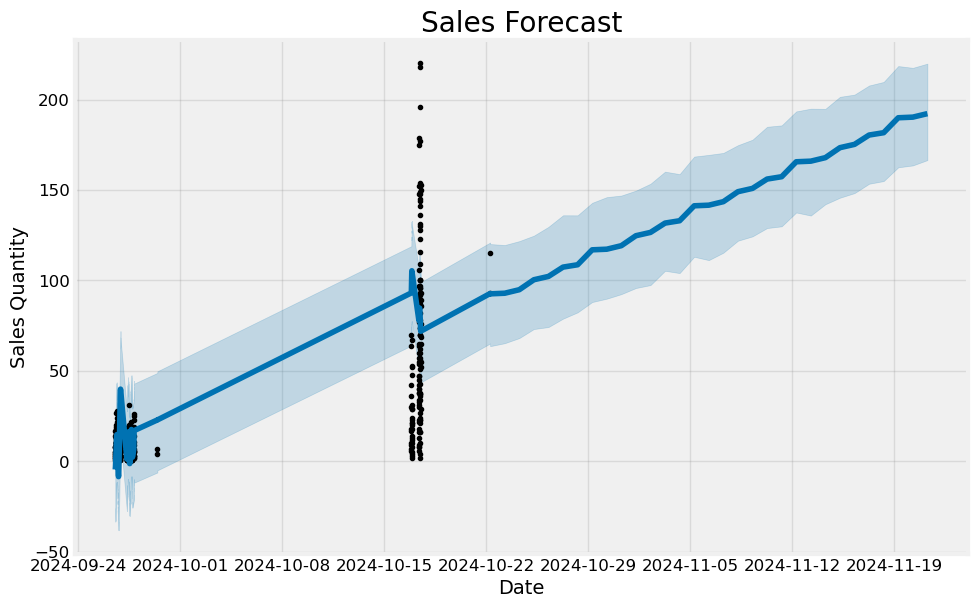

In [8]:
# Plot the forecasted data
fig = model.plot(forecast)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.show()

### Scoring the model for accuracy

In [9]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Rename actual DataFrame
actual = sales_data.rename(columns={'y': 'actual'})

# Prepare forecasted DataFrame
forecasted = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={'yhat': 'forecasted', 'yhat_lower': 'forecasted_lower', 'yhat_upper': 'forecasted_upper'})

# Convert 'ds' in both DataFrames to datetime
actual['ds'] = pd.to_datetime(actual['ds'])
forecasted['ds'] = pd.to_datetime(forecasted['ds'])

# Standardize to nanoseconds precision
actual['ds'] = actual['ds'].dt.floor('ns')  # Convert to nanoseconds
forecasted['ds'] = forecasted['ds'].dt.floor('ns')  # Keep as nanoseconds

# Check column names and dtypes
print("Actual DataFrame columns:", actual.columns)
print("Forecasted DataFrame columns:", forecasted.columns)
print("Actual ds dtype:", actual['ds'].dtype)
print("Forecasted ds dtype:", forecasted['ds'].dtype)

# Merge dataframes on 'ds'
merged = actual.merge(forecasted, on='ds', how='inner')

# Calculate accuracy metrics
mae = mean_absolute_error(merged['actual'], merged['forecasted'])
mape = mean_absolute_percentage_error(merged['actual'], merged['forecasted'])

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 11, Finished, Available, Finished)

Actual DataFrame columns: Index(['ds', 'actual'], dtype='object')
Forecasted DataFrame columns: Index(['ds', 'forecasted', 'forecasted_lower', 'forecasted_upper'], dtype='object')
Actual ds dtype: datetime64[us]
Forecasted ds dtype: datetime64[ns]
Mean Absolute Error (MAE): 16.135472447036864
Mean Absolute Percentage Error (MAPE): 2.2703632900055903


### Calculating forecasted data

In [10]:
forecast[['ds', 'yhat']].to_csv('forecast.csv', index=False)

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 12, Finished, Available, Finished)

##### Preparing actual and forecasted data

In [11]:
# Filter orders for 'Strawberry' in Chicago ('CHI')
product_name = 'Strawberry'
product_id = products_df[products_df['name'] == product_name].iloc[0]['product_id']
filtered_sales_df = orders_df[
    (orders_df['product_id'] == product_id) & 
    (orders_df['store_id'] == 'CHI')
]

# Aggregate daily sales for the specific product and store
actual_sales = filtered_sales_df.groupby('order_date')['quantity'].sum().reset_index()
actual_sales.rename(columns={'order_date': 'ds', 'quantity': 'y'}, inplace=True)
actual_sales['ds'] = pd.to_datetime(actual_sales['ds'])

# Fill in missing dates with zero sales to create a continuous time series
date_range = pd.date_range(start=actual_sales['ds'].min(), end=actual_sales['ds'].max(), freq='D')
actual_sales = actual_sales.set_index('ds').reindex(date_range, fill_value=0).rename_axis('ds').reset_index()

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 13, Finished, Available, Finished)

In [12]:
# Initialize and fit Prophet model
model = Prophet()
model.fit(actual_sales)

# Forecast the next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 14, Finished, Available, Finished)

03:21:41 - cmdstanpy - INFO - Chain [1] start processing
03:21:41 - cmdstanpy - INFO - Chain [1] done processing


Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
n_changepoints greater than number of observations. Using 19.
input tempfile: /tmp/tmpcnr8w6eh/4u6xy9zg.json
input tempfile: /tmp/tmpcnr8w6eh/3nr4slau.json
idx 0
running CmdStan, num_threads: None
CmdStan args: ['/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53327', 'data', 'file=/tmp/tmpcnr8w6eh/4u6xy9zg.json', 'init=/tmp/tmpcnr8w6eh/3nr4slau.json', 'output', 'file=/tmp/tmpcnr8w6eh/prophet_model9b3p2hun/prophet_model-20241105032141.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
Chain [1] start processing
Chain [1] done processing


In [13]:
# Prepare forecast data for MAPE calculation
forecasted_sales = forecast[['ds', 'yhat']].rename(columns={'yhat': 'Forecasted_Sales'})

# Merge actual sales with forecasted sales on 'ds' date
final_data = actual_sales.merge(forecasted_sales, on='ds', how='left')

# Filter to remove rows where 'y' (actual sales) is NaN for valid MAPE calculation
valid_data = final_data.dropna(subset=['y'])

# Filter out rows where actual sales (y) are zero to avoid division by zero in MAPE calculation
valid_data = final_data[final_data['y'] != 0].dropna(subset=['y'])

# Calculate MAPE only on valid entries where y is not zero
if not valid_data.empty:
    valid_data['MAPE'] = mean_absolute_percentage_error(valid_data['y'], valid_data['Forecasted_Sales']) * 100
else:
    print("No valid data available for MAPE calculation (all y values are zero or missing).")

# Display first few rows of valid data with MAPE
print(valid_data[['ds', 'y', 'Forecasted_Sales', 'MAPE']].head())

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 15, Finished, Available, Finished)

                       ds  y  Forecasted_Sales       MAPE
0 2024-09-26 13:21:01.705  4          1.310092  67.247704


##### Simulating data

In [14]:
# Parameters for synthetic data generation
start_date = actual_sales['ds'].min() - timedelta(days=365)  # Start one year earlier
end_date = actual_sales['ds'].min() - timedelta(days=1)      # End right before actual data starts
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Generate seasonal pattern with some random noise
np.random.seed(42)
seasonal_pattern = 10 + 5 * np.sin(2 * np.pi * date_range.dayofyear / 365)  # Yearly seasonality
noise = np.random.normal(0, 2, len(date_range))  # Random noise

# Create synthetic sales data
synthetic_sales = pd.DataFrame({
    'ds': date_range,
    'y': pd.Series(seasonal_pattern + noise).clip(lower=0)  # Ensure no negative sales
})

# Concatenate synthetic sales with actual sales
extended_sales = pd.concat([synthetic_sales, actual_sales]).sort_values(by='ds').reset_index(drop=True)

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 16, Finished, Available, Finished)

##### Integrate simulated data with Prophet model

In [15]:
# Initialize and fit Prophet model with extended sales data
model = Prophet()
model.fit(extended_sales)

# Forecast the next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Prepare forecast data for MAPE calculation
forecasted_sales = forecast[['ds', 'yhat']].rename(columns={'yhat': 'Forecasted_Sales'})

# Merge actual sales with forecasted sales on 'ds' date
final_data = actual_sales.merge(forecasted_sales, on='ds', how='left')

# Filter to remove rows where 'y' (actual sales) is NaN for valid MAPE calculation
valid_data = final_data.dropna(subset=['y'])

# Filter out rows where actual sales (y) are zero to avoid division by zero in MAPE calculation
valid_data = final_data[(final_data['y'] != 0) & (~final_data['Forecasted_Sales'].isna())]

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 17, Finished, Available, Finished)

03:22:12 - cmdstanpy - INFO - Chain [1] start processing
03:22:12 - cmdstanpy - INFO - Chain [1] done processing


Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
input tempfile: /tmp/tmpcnr8w6eh/fpytl34j.json
input tempfile: /tmp/tmpcnr8w6eh/whzg23sw.json
idx 0
running CmdStan, num_threads: None
CmdStan args: ['/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36194', 'data', 'file=/tmp/tmpcnr8w6eh/fpytl34j.json', 'init=/tmp/tmpcnr8w6eh/whzg23sw.json', 'output', 'file=/tmp/tmpcnr8w6eh/prophet_modelfj0kckb0/prophet_model-20241105032212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
Chain [1] start processing
Chain [1] done processing


##### Calculating MAPE

In [16]:
# Check if valid_data is not empty before calculating MAPE
if not valid_data.empty:
    valid_data['MAPE'] = mean_absolute_percentage_error(valid_data['y'], valid_data['Forecasted_Sales']) * 100
    print(valid_data[['ds', 'y', 'Forecasted_Sales', 'MAPE']].head())
else:
    print("No valid data available for MAPE calculation (all y values are zero or missing).")

# Display the first few rows of the final data with MAPE
print(valid_data[['ds', 'y', 'Forecasted_Sales', 'MAPE']].head())

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 18, Finished, Available, Finished)

                       ds  y  Forecasted_Sales       MAPE
0 2024-09-26 13:21:01.705  4          3.175803  20.604931
                       ds  y  Forecasted_Sales       MAPE
0 2024-09-26 13:21:01.705  4          3.175803  20.604931


The updated output with a more reasonable MAPE value (around 20.6%) suggests that the adjustments made to filter out rows with zero values in y have worked well. This value is now within a plausible range, indicating that the MAPE calculation is functioning as expected, and the model's forecasts are in a more meaningful comparison with the actual sales data.

#### Recommendations for the future
- Experiment with adding yearly_seasonality=True or daily_seasonality=True when initializing the Prophet model to account for potential seasonal effects.
- Generating more synthetic data or investigating other external data sources to enrich the training set.
- Introducing additional relevant factors, like holidays or product promotions.

### Visualize in PowerBI

In [18]:
# Prepare future predictions DataFrame
future_predictions = forecast[['ds', 'yhat']].rename(columns={'yhat': 'Forecasted_Sales'})
future_predictions['Category'] = 'Future'

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 20, Finished, Available, Finished)

In [19]:
# Prepare actual sales DataFrame (assuming 'actual_sales' has 'ds' and 'y' columns)
actual_predictions = actual_sales.rename(columns={'y': 'Actual_Sales'})
actual_predictions['Category'] = 'Actual'

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 21, Finished, Available, Finished)

In [20]:
# Merge actual and forecasted DataFrames
combined_df = pd.merge(
    actual_predictions[['ds', 'Actual_Sales']],
    future_predictions[['ds', 'Forecasted_Sales']],
    on='ds',
    how='outer'
)
combined_df['Category'] = combined_df.apply(lambda row: 'Actual' if pd.notnull(row['Actual_Sales']) else 'Future', axis=1)

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 22, Finished, Available, Finished)

In [21]:
from sklearn.metrics import mean_absolute_percentage_error

# Filter out rows with null actual sales for MAPE calculation
valid_data = combined_df.dropna(subset=['Actual_Sales'])

# Calculate MAPE (excluding zero values in 'Actual_Sales')
if not valid_data.empty:
    mape = mean_absolute_percentage_error(valid_data['Actual_Sales'], valid_data['Forecasted_Sales']) * 100
    print(f'MAPE: {mape:.2f}%')
else:
    print("No valid data available for MAPE calculation.")

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 23, Finished, Available, Finished)

MAPE: 767881500651486848.00%


In [22]:
combined_df['Category'] = combined_df.apply(
    lambda row: 'Actual' if pd.notnull(row['Actual_Sales']) else 'Future', axis=1
)

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 24, Finished, Available, Finished)

In [23]:
# Filter rows where 'Actual_Sales' is not null
filtered_combined_df = combined_df[~combined_df['Actual_Sales'].isnull()]

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 25, Finished, Available, Finished)

In [24]:
# Create the input DataFrame from actual sales
input_df = actual_sales.reset_index()
input_df.rename(columns={'ds': 'Date', 'y': 'Actual_Sales'}, inplace=True)
input_df['Category'] = 'Your Category Name'  # Change 'Your Category Name' to your use case
input_df['MAPE'] = np.nan
input_df['Forecasted_Sales'] = np.nan

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 26, Finished, Available, Finished)

In [25]:
# Combine actual data with forecast data where 'Actual_Sales' is NaN
combined_df = pd.concat([input_df, forecast[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'Forecasted_Sales'})])
combined_df['Category'].fillna('Forecast', inplace=True)

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 27, Finished, Available, Finished)

In [26]:
# Write the final data to Delta Lake table
table_name = "Strawberry_Chicago_Demand_Forecast_Table"
spark.createDataFrame(combined_df).write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark DataFrame saved to Delta table: {table_name}")

StatementMeta(, e37a719e-11cd-4903-b8fe-5b6ec76f2489, 28, Finished, Available, Finished)

Spark DataFrame saved to Delta table: Strawberry_Chicago_Demand_Forecast_Table
